In [17]:
%load_ext autoreload
%autoreload 2

import cv2
import h5py
import pandas as pd
import scanpy as sc 
import os
import ipdb
import openslide
import numpy as np
from tqdm import tqdm
import matplotlib.colors as mcolors
import torch
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# slide_id = "TCGA-73-4676-01Z-00-DX1.4d781bbc-a45e-4f9d-b6b6-2265282dff99"
# slide_id = 'TCGA-MP-A4T6-01Z-00-DX1.085C4F5A-DB1B-434A-9D62-E2187D133B0A'
# slide_id = "TCGA-L9-A444-01Z-00-DX1.88CF6F01-0C1F-4572-81E3-1A5790692861"
slide_id = "TCGA-05-4402-01Z-00-DX1.c653ddc2-88c1-45ac-88e7-4e512b8e8d53"
# slide_id = "TCGA-44-6774-01Z-00-DX1.f169485b-f863-4be0-9844-258d78170b64"
# slide_id = "a0f29ff13fb03dd08b6aaeaf4bcac6ed"
# slide_id = "0a0f8e20b1222b69416301444b117678"
# slide_id = "TCGA-GU-A42R-01Z-00-DX2.B54CCE4D-E4DE-473B-B7C6-5A349FD7F55C"
wsi_dir = "/data1/r20user2/wsi_data/TCGA_NSCLC/WSIs"
# wsi_dir = "/data1/r20user2/wsi_data/PANDA/WSIs"
# wsi_dir = "/data1/r20user2/wsi_data/TCGA_BLCA/WSIs"
wsi_path = os.path.join(wsi_dir, f"{slide_id}.svs")
# wsi_path = os.path.join(wsi_dir, f"{slide_id}.tiff")
# graph_dir = "/data1/r20user2/wsi_data/PANDA/extracted_mag20x_patch256/uni_pt_patch_features/superpatch_graph"
# graph_dir = "/data1/r20user2/wsi_data/TCGA_BLCA/extracted_mag20x_patch256/uni_pt_patch_features/superpatch_ot_graph"
# graph_dir = "/data1/r20user2/wsi_data/TCGA_BLCA/extracted_mag20x_patch256/uni_pt_patch_features/superpatch_graph"
# graph_dir = "/data1/r20user2/wsi_data/TCGA_NSCLC/extracted_mag20x_patch256/uni_pt_patch_features/WSI_graph"
graph_dir = "/data1/r20user2/wsi_data/TCGA_NSCLC/extracted_mag20x_patch256/uni_pt_patch_features/superpatch_connected_panther_graph"
# graph_dir = "/data1/r20user2/wsi_data/PANDA/extracted_mag20x_patch256/uni_pt_patch_features/superpatch_connected_panther_graph"
graph_path = os.path.join(graph_dir, f"{slide_id}.pt")
pt_dir = "/data1/r20user2/wsi_data/TCGA_NSCLC/extracted_mag20x_patch256/uni_pt_patch_features/pt_files"
# pt_dir = "/data1/r20user2/wsi_data/PANDA/extracted_mag20x_patch256/uni_pt_patch_features/pt_files"
# pt_dir = "/data1/r20user2/wsi_data/PANDA/extracted_mag20x_patch256/uni_pt_patch_features/pt_files"
# pt_dir = "/data1/r20user2/wsi_data/TCGA_BLCA/extracted_mag20x_patch256/uni_pt_patch_features/pt_files"
pt_path = os.path.join(pt_dir, f"{slide_id}.pt")
pt_data = torch.load(pt_path)
graph_data = torch.load(graph_path)
slide_prototype_dir = "/data1/r20user2/wsi_data/TCGA_NSCLC/extracted_mag20x_patch256/uni_pt_patch_features/cluster_feats"
# slide_prototype_dir = "/data1/r20user2/wsi_data/PANDA/extracted_mag20x_patch256/uni_pt_patch_features/cluster_feats"
# slide_prototype_dir = "/data1/r20user2/wsi_data/TCGA_BLCA/extracted_mag20x_patch256/uni_pt_patch_features/cluster_feats"
slide_prototype_path = os.path.join(slide_prototype_dir, f"{slide_id}.h5ad")
slide_prototype = sc.read_h5ad(slide_prototype_path)

/tmp/ipykernel_642580/1462072320.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_data = torch.load(pt_path)
/tmp/ipykernel_642580/1462072320.py:27: FutureWarning: Yo

In [19]:
graph_data

Data(x=[54, 32784], edge_index=[2, 213], centroid=[54, 2])

(-0.5, 145.5, 130.5, -0.5)

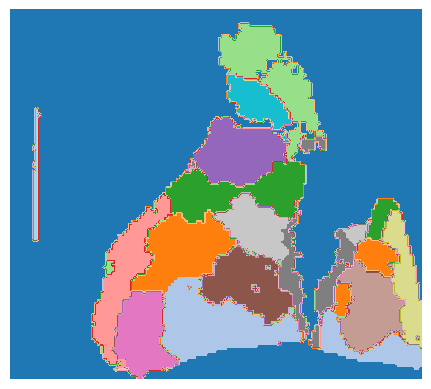

In [20]:
max_coords = np.max(slide_prototype.obsm["spatial"], axis=0) + 1
max_coords
heatmap = np.zeros((int(max_coords[0]), int(max_coords[1]))) 
unique_labels = np.unique(slide_prototype.obs["spatialleiden"])
for label in unique_labels:
    coords = slide_prototype.obsm["spatial"][slide_prototype.obs["spatialleiden"] == label]
    for coord in coords:
        heatmap[int(coord[0]), int(coord[1])] = label + 1
plt.imshow(heatmap.T, cmap="tab20")
plt.axis("off")

In [21]:
# plot topk subbgraphs and whole WSI
# wsi_path = os.path.join(RCC_DATA_DIR, "WSIs", f"{slide_id}.svs")
wsi = openslide.open_slide(wsi_path)
downscale = 512
vis_level = wsi.get_best_level_for_downsample(downscale)
print(f"vis_level: {vis_level}")
w, h = wsi.level_dimensions[vis_level]
print(w, h)
downsamples = wsi.level_downsamples[vis_level]
print(downsamples)

patch_size = 512
vis_patch_size = int(patch_size / downsamples)
whole_wsi = np.array(wsi.read_region((0, 0), level=vis_level, size=(w, h)).convert("RGB"))

vis_level: 3
1264 1564
64.0


In [22]:
def hex_to_rgb_mpl_255(hex_color):
    rgb = mcolors.to_rgb(hex_color)
    return tuple([int(x*255) for x in rgb])


def get_default_cmap(n=32):
    colors = [
        '#696969','#556b2f','#a0522d','#483d8b', 
        '#008000','#008b8b','#000080','#7f007f',
        '#8fbc8f','#b03060','#ff0000','#ffa500',
        '#00ff00','#8a2be2','#00ff7f', '#FFFF54', 
        '#00ffff','#00bfff','#f4a460','#adff2f',
        '#da70d6','#b0c4de','#ff00ff','#1e90ff',
        '#f0e68c','#0000ff','#dc143c','#90ee90',
        '#ff1493','#7b68ee','#ffefd5','#ffb6c1'
    ]
    
    colors = colors[:n]
    label2color_dict = dict(zip(range(n), [hex_to_rgb_mpl_255(x) for x in colors]))
    return label2color_dict


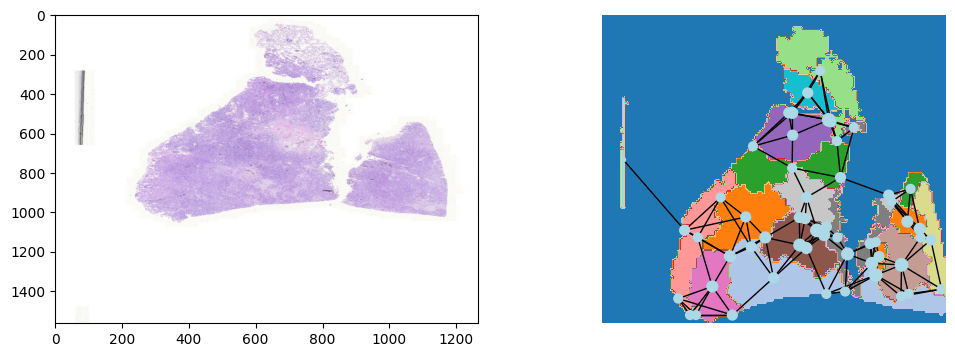

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(12)
ax1.imshow(whole_wsi, aspect="auto")

if hasattr(graph_data, "centroid"):
    # node_pos = graph_data.centroid.cpu().numpy() * 512 / downsamples
    node_pos = graph_data.centroid.cpu().numpy()
else:
    # node_pos = graph_data.pos.cpu().numpy() * 512 / downsamples
    node_pos = graph_data.pos.cpu().numpy()

if graph_data.edge_index is None:
    row, col = graph_data.adj_t.to_dense().nonzero().t().contiguous()
    edge_index = torch.stack([row, col], dim=0)
    graph_data.edge_index = edge_index

edges = graph_data.edge_index
same_node = edges[0] == edges[1]
edges = edges[:, ~same_node]
graph_data.edge_index = edges
G = to_networkx(graph_data, to_undirected=True)
# node_pos = node_pos[:, ::-1]
d = dict(enumerate(node_pos))

# nodesize=30
# nx.draw_networkx_nodes(G, pos=d, node_color="red", node_size=nodesize, ax=ax2)
# nx.draw_networkx_edges(G, pos=d, edge_color="black", arrows=False, alpha=1, width=3, ax=ax2)
deg = dict(G.degree)
nodesize = 10
nx.draw(G, pos=d, node_color='lightblue', nodelist=d, node_size=[deg[k]*nodesize for k in deg], ax=ax2)
ax2.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax2.imshow(heatmap.T, cmap="tab20")
# ax2.imshow(whole_wsi)

(-0.5, 1263.5, 1563.5, -0.5)

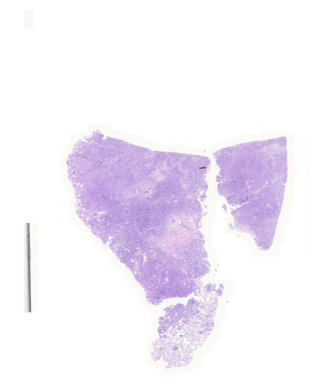

In [35]:
plt.imshow(whole_wsi[::-1])
plt.axis("off")

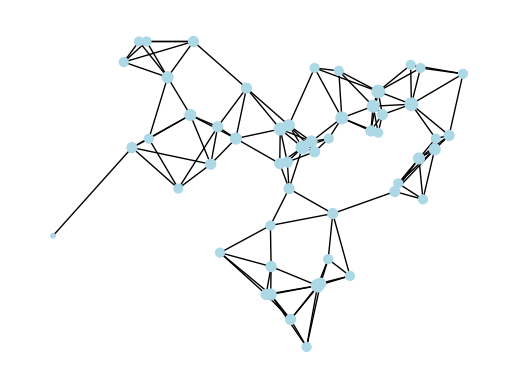

In [38]:
fig, ax = plt.subplots(1, 1)
deg = dict(G.degree)
nodesize = 10
nx.draw(G, pos=d, node_color='lightblue', nodelist=d, node_size=[deg[k]*nodesize for k in deg], ax=ax)
# nx.draw_networkx_edges(G, pos=d, edge_color="black", arrows=False, alpha=1, width=3, ax=ax)
# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
# ax.imshow(heatmap.T, cmap="tab20")
# ax.set_axis_off()

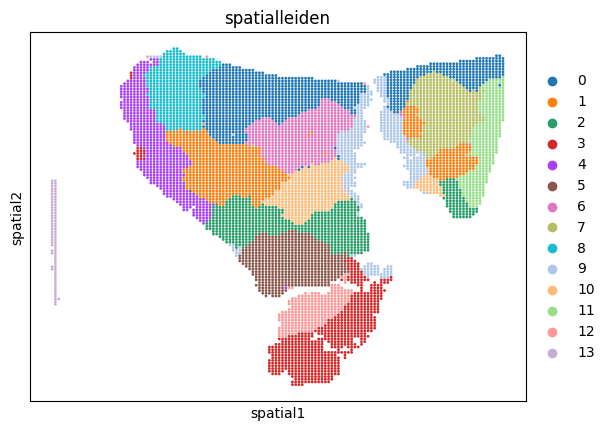

In [26]:
sc.pl.embedding(slide_prototype, basis="spatial", color=["spatialleiden"])

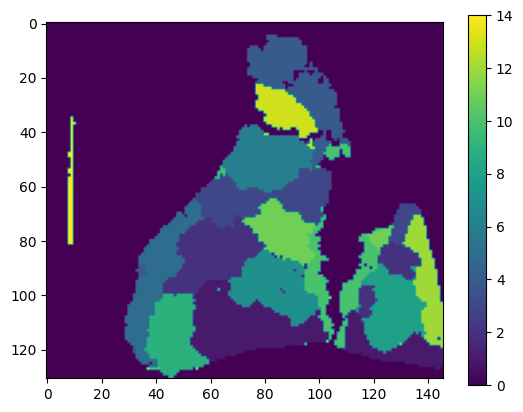

In [27]:
plt.imshow(heatmap.T)
plt.colorbar()